In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, Dropout
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import sklearn.preprocessing 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.metrics import Precision, Recall, FalseNegatives, FalsePositives, AUC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Expectations

We expect you to

deliver a reasonable solution in about 2 hours, 3 hours max
return the results in 3-5 days 
build an end-to-end pipeline for the task
showcase skills of various aspects of ML: ETL, feature engineering, model building and tuning, evaluation, etc.
develop in Python3 (could be in Jupiter notebooks) with comments
optionally, use version control with appropriate commit messages
Note: You should not try to deliver the “best” solution. Instead, they should try to get a minimum-viable-product (MVP) which is just enough as the first response to the challenge (feel free to comment on how to improve). 

# Introduction

File descriptions

- train.csv - the training set
- train_sample.csv - 100,000 randomly-selected rows of training data, to inspect data before downloading full set
- test.csv - the test set
- sampleSubmission.csv - a sample submission file in the correct format

UPDATE: test_supplement.csv - This is a larger test set that was unintentionally released at the start of the competition. It is not necessary to use this data, but it is permitted to do so. The official test data is a subset of this data.
Data fields

Each row of the training data contains a click record, with the following features.

- ip: ip address of click.
- app: app id for marketing.
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download
- is_attributed: the target that is to be predicted, indicating the app was downloaded

Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

click_id: reference for making predictions
is_attributed: not included

# Import Data

In [2]:
dataset = pd.read_csv("./data/talkingdata-adtracking-fraud-detection/train.csv", nrows=5000000)
dataset

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0
...,...,...,...,...,...,...,...,...
4999995,55695,8,1,16,145,2017-11-06 20:27:57,NaN,0
4999996,37363,15,1,25,245,2017-11-06 20:27:57,NaN,0
4999997,138561,94,1,13,361,2017-11-06 20:27:57,NaN,0
4999998,97361,12,1,35,19,2017-11-06 20:27:57,NaN,0


# Exploratory Data Analysis
From inspection of the data we can see that there has already been some encoding of the features, specifically, ip, add, device, os, and channel.

From the plot below we can see that the dataset is heavily imbalanced. In order to provide accurate predictions, we will need to rebalance this dataset some how, either through oversampling, or undersampling

In [3]:
dataset.isna().sum()

ip                       0
app                      0
device                   0
os                       0
channel                  0
click_time               0
attributed_time    4991046
is_attributed            0
dtype: int64

In [4]:
dataset = dataset.fillna(0)

From the plot below we can see that the dataset is heavily imbalanced. In order to provide accurate predictions, we will need to rebalance this dataset some how, either through oversampling, or undersampling

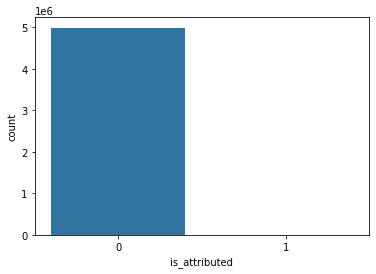

In [5]:
f = sns.countplot(data=dataset, x="is_attributed")

In [6]:
len_is_true = len(dataset[dataset.is_attributed==True])
len_is_false = len(dataset[dataset.is_attributed==False])

print(f"is_attributed true: {len(dataset[dataset.is_attributed==True])/(len(dataset))*100} %")
print(f"is_attributed false: {len(dataset[dataset.is_attributed==False])/(len(dataset))*100} %")

is_attributed true: 0.17908 %
is_attributed false: 99.82092 %


As can be seen from the distribution of is_attributed above. There is a very small number of positive values. This is a very imbalanced problem. An approach like SMOTE, may not be useful here as it synthetically generates data from the minority class. If like this example we have a very limited number of positive samples we may just end up fitting model to the noise

Introducing hours, month, day into the feature dataset may help us identify some periodicity in the data.

In [7]:
dataset["click_time"] = pd.to_datetime(dataset["click_time"])
dataset["click_days"] = [x.day for x in dataset["click_time"]]
dataset["click_hour"] = [x.hour for x in dataset["click_time"]]
dataset["click_minute"] = [x.minute for x in dataset["click_time"]]
dataset

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_days,click_hour,click_minute
0,83230,3,1,13,379,2017-11-06 14:32:21,0,0,6,14,32
1,17357,3,1,19,379,2017-11-06 14:33:34,0,0,6,14,33
2,35810,3,1,13,379,2017-11-06 14:34:12,0,0,6,14,34
3,45745,14,1,13,478,2017-11-06 14:34:52,0,0,6,14,34
4,161007,3,1,13,379,2017-11-06 14:35:08,0,0,6,14,35
...,...,...,...,...,...,...,...,...,...,...,...
4999995,55695,8,1,16,145,2017-11-06 20:27:57,0,0,6,20,27
4999996,37363,15,1,25,245,2017-11-06 20:27:57,0,0,6,20,27
4999997,138561,94,1,13,361,2017-11-06 20:27:57,0,0,6,20,27
4999998,97361,12,1,35,19,2017-11-06 20:27:57,0,0,6,20,27


Sample dataset containing a three days worth of data. 

In [8]:
dataset["click_time"].min(), dataset["click_time"].max()

(Timestamp('2017-11-06 14:32:21'), Timestamp('2017-11-06 20:27:57'))

Another feature we could seek to introduce is a type of click rate. The number of clicks per IP, Per App, Per Device, Per Os and Per Channel. We can do this by grouping by these features and counting the number of entries over a given time period

In [9]:
def time_window(d, feature, period="60S", time_column="click_time"):
    """
    d: pandas dataframe to be grouped
    feature: The feature to group by
    period: is the period of time to groupby
    time_column: column in dataframe containing timestamp
    
    returns: grouped pandas dataframe
    """
#     d_grouped = d.groupby(feature).count()
    
    d_resampled = d.copy()
    d_resampled["timestamp"] = d_resampled[time_column]
    d_resampled = d_resampled.set_index("timestamp").resample(period)
    return d_resampled
    

In [10]:
time_window(dataset, feature="ip").count()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_days,click_hour,click_minute
timestamp,,,,,,,,,,,
2017-11-06 14:32:00,1,1,1,1,1,1,1,1,1,1,1
2017-11-06 14:33:00,1,1,1,1,1,1,1,1,1,1,1
2017-11-06 14:34:00,2,2,2,2,2,2,2,2,2,2,2
2017-11-06 14:35:00,1,1,1,1,1,1,1,1,1,1,1
2017-11-06 14:36:00,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2017-11-06 20:23:00,7290,7290,7290,7290,7290,7290,7290,7290,7290,7290,7290
2017-11-06 20:24:00,6763,6763,6763,6763,6763,6763,6763,6763,6763,6763,6763
2017-11-06 20:25:00,6628,6628,6628,6628,6628,6628,6628,6628,6628,6628,6628


In [11]:
indexes = dataset.groupby(["ip","click_time"]).count().reset_index()[["ip","click_time"]]

## Feature Pipeline

In [12]:
def iterate_grouping_for_different_features(d, features, time_agg):
    """
    Function to iterate through list of features and group data
    d: pandas dataframe, your input dataset
    features: Features to group by
    time_agg: time unit aggregation
    
    returns list_of_features
    """
    list_of_features = []
    for i in features:
        for j in time_agg:
            list_of_features.append([
                count_by_unit_of_time(
                    d, 
                    groupby_feature=i, 
                    time_feature=j),
                i,
                j
            ]
            )
    return list_of_features

def count_by_unit_of_time(d, groupby_feature="ip", time_feature="click_hour"):
    """
    Function to groupby unit of time and count
    
    d: pandas dataframe
    returns: grouped pandas dataframe
    """
    count = d.groupby([groupby_feature, time_feature]).count().reset_index()\
        [[groupby_feature, time_feature ,"click_time"]]
    count = count.rename(columns={"click_time": f"count_{groupby_feature}_{time_feature}"})
    return count


In [13]:
class feature_pipeline():
        
    def add_time_features(self):
        """
        Adds additional click time features to dataset.
        
        """
        self.dataset["click_time"] = pd.to_datetime(self.dataset["click_time"])
        self.dataset["click_days"] = [x.day for x in self.dataset["click_time"]]
        self.dataset["click_hour"] = [x.hour for x in self.dataset["click_time"]]
        self.dataset["click_minute"] = [x.minute for x in self.dataset["click_time"]]
        
        
    def add_grouping_features(self, 
                              features=["ip","app","device","os", "channel"],
                              time_agg=["click_hour","click_minute"]):
        """
        Adds grouping features to dataset
        """
        self.list_of_features = iterate_grouping_for_different_features(
            self.dataset,
            features=features, 
            time_agg=time_agg)
        self.length_of_list_of_features = len(self.list_of_features)
        
        
    def merge_grouped_features_to_dataset(self):
        """
        Merges grouped features onto original dataset
        """
        self.dataset_clean = self.dataset.copy()
        for i in range(self.length_of_list_of_features):
            self.dataset_clean = pd.merge( 
                self.dataset_clean, 
                self.list_of_features[i][0], 
                on=[
                    self.list_of_features[i][1],
                    self.list_of_features[i][2]
                ], 
                how="inner"
                )
            
    
    def create_validation_set(self):
        """
        Creates Validation Dataset
        """
        
        self.features, self.xval, self.target, self.yval = train_test_split(
            self.features,
            self.target,
            test_size=0.33, 
            random_state=42
        )
    
    
            
    def min_max_scaling_of_features(self, is_training=True):
        """
        Performs MinMax Scaling on numerical features
        """
        cols = [x for x in self.dataset_clean if "count" in x]
        if is_training:
            self.min_max = sklearn.preprocessing.MinMaxScaler()
        for i in cols:
            if is_training:
                self.min_max.fit(self.dataset_clean[i].values.reshape(-1,1))
            self.dataset_clean[i] = self.min_max\
                .transform(self.dataset_clean[i].values.reshape(-1,1))
        
            
            
    def drop_columns(self,
                     columns=["is_attributed","click_time", "attributed_time"],
                     target="is_attributed"):
        """
        Drops unneded columns and removes features
        """
        self.features = self.dataset_clean.drop(columns=columns)
        self.target = self.dataset_clean[target]
        
        
    def resample_data(self):
        """
        Resample Data Classes
        """
        undersample = NearMiss(version=1, n_neighbors=3)
        
        self.create_validation_set()
        
        self.features_resampled, self.target_resampled = undersample.\
            fit_resample(self.features, self.target)       
        
        
        
    def execute_pipeline(self, dataset, is_training=True):
        """
        Execute Training Pipeline
        """
        self.dataset = dataset
        
        self.add_time_features()
        self.add_grouping_features()
        self.merge_grouped_features_to_dataset()
        self.min_max_scaling_of_features(is_training=is_training)
        if is_training:
            self.drop_columns()
        self.resample_data()
        return self.features_resampled, self.target_resampled

In [14]:
dataset = pd.read_csv("./data/talkingdata-adtracking-fraud-detection/train.csv", nrows=10000)
fp = feature_pipeline()
features, target = fp.execute_pipeline(dataset)

### Model (Random Forest)

Given from previous analysis we see that the minority class has a very small size and we are using undersampling, will investigate

- Impact of dataset size of model training accuracy
- Hyper parameter grid search
- Application to the test data

### Impact of training data size on predictions.

In [15]:
sample_size = [10000, 100000, 500000, 1000000, 2000000, 3000000]
rf_performance = []

for k in tqdm(sample_size):
    dataset = pd.read_csv("./data/talkingdata-adtracking-fraud-detection/train.csv", nrows=k)
    fp = feature_pipeline()
    features, target = fp.execute_pipeline(dataset)
    
    rf = RandomForestClassifier(random_state=42)
    rf.fit(features, target)
    ypred = rf.predict(fp.xval)
    
    scores = cross_val_score(rf, features, target, cv=5)
    rf_performance.append([k, scores.mean(), rf, fp, len(features)])

In [16]:
plotting_data = []
for i in range(len(rf_performance)):
    plotting_data.append([rf_performance[i][0], rf_performance[i][1], rf_performance[i][-1]])

In [17]:
plotting_data = pd.DataFrame(plotting_data, columns=["sample_size","accuracy", "training_length"])

Text(0, 0.5, 'Length of dataset')

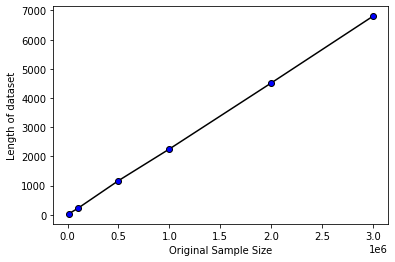

In [18]:
plt.plot(plotting_data["sample_size"], plotting_data["training_length"], '-ok', markerfacecolor="b")
plt.xlabel("Original Sample Size")
plt.ylabel("Length of dataset")

Text(0, 0.5, 'Accuracy')

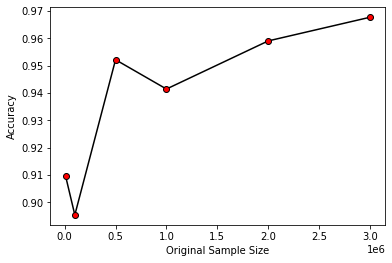

In [19]:
plt.plot(plotting_data["sample_size"], plotting_data["accuracy"], '-ok', markerfacecolor="r")
plt.xlabel("Original Sample Size")
plt.ylabel("Accuracy")

### Hyper Parameter Tuning and Grid Search

In [20]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [21]:
rf_random = RandomizedSearchCV(estimator=rf_performance[-1][-3], 
                               param_distributions = random_grid,
                               n_iter = 100, 
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)
# Fit the random search model
rf_random.fit(features, target)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [22]:
xval = rf_performance[3][-2].xval
yval = rf_performance[3][-2].yval

best_random = rf_random.best_estimator_
best_random.score(xval, yval)


0.0538

The performance here is not good. Although we have good accuracy in the training, the model doesnt generalise well to the validation dataset. This implies over fitting however we would expect the variation of the number of estimators in the forest to prevent overfitting (more estimators should reduce the probability of overfitting). 

# Model (NN)

In [23]:
def classification_model(shape=features.shape[1]):
    inputs = Input(shape,)
    x = Dense(128, activation="relu")(inputs)
    x = Dense(16, activation="relu")(x)
    x = layers.Dense(
            units=64,
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5)
    )(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu")(x)
    
    output = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs, output)
    
    # compile model
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[
                                                                         'accuracy',
                                                                         Precision(),
                                                                         Recall(),
                                                                         FalseNegatives(),
                                                                         FalsePositives(),
                                                                         AUC()
                                                                         ])
    return model

In [24]:
early_stopping = EarlyStopping(
    monitor='accuracy',
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

In [25]:
model = classification_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2432      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512 

In [26]:
dataset = pd.read_csv("./data/talkingdata-adtracking-fraud-detection/train.csv", nrows=3000000)
fp = feature_pipeline()
features, target = fp.execute_pipeline(dataset)

In [27]:
model_history = model.fit(
    features,
    target, 
    batch_size=8,
    epochs=100,
    callbacks=[early_stopping],
    validation_split=.30)

Epoch 1/100
596/596 [==============================] - 4s 4ms/step - loss: 1042.6939 - accuracy: 0.6858 - precision: 0.3435 - recall: 0.0748 - false_negatives: 665.1407 - false_positives: 47.1122 - auc: 0.5110 - val_loss: 1.2978 - val_accuracy: 0.0029 - val_precision: 1.0000 - val_recall: 0.0029 - val_false_negatives: 2035.0000 - val_false_positives: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/100
596/596 [==============================] - 1s 2ms/step - loss: 0.5995 - accuracy: 0.7183 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_negatives: 679.7839 - false_positives: 0.0000e+00 - auc: 0.4977 - val_loss: 1.1859 - val_accuracy: 0.0020 - val_precision: 1.0000 - val_recall: 0.0020 - val_false_negatives: 2037.0000 - val_false_positives: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 3/100
596/596 [==============================] - 1s 2ms/step - loss: 0.5965 - accuracy: 0.7211 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_negatives: 669.8141 - false_positives: 0.0000e+00 - auc: 0.4982 - 

Epoch 22/100
596/596 [==============================] - 1s 2ms/step - loss: 0.6058 - accuracy: 0.7094 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_negatives: 685.8141 - false_positives: 0.0000e+00 - auc: 0.4859 - val_loss: 1.2991 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_negatives: 2041.0000 - val_false_positives: 0.0000e+00 - val_auc: 0.0000e+00
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


Text(0, 0.5, 'Recall')

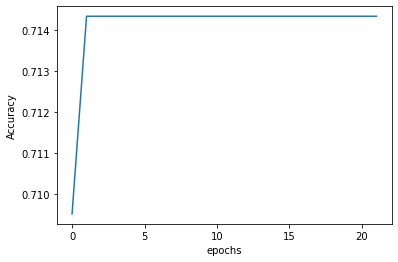

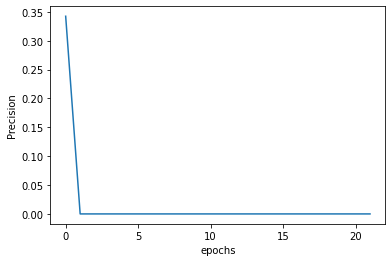

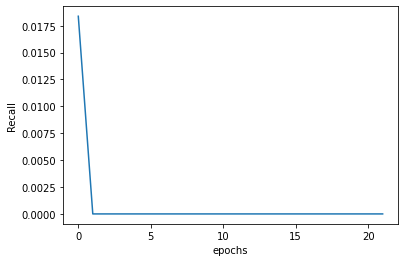

In [28]:
plt.figure()
plt.plot(model_history.history["accuracy"], label="accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")

plt.figure()
plt.plot(model_history.history["precision"], label="precision")
plt.xlabel("epochs")
plt.ylabel("Precision")

plt.figure()
plt.plot(model_history.history["recall"], label="recall")
plt.xlabel("epochs")
plt.ylabel("Recall")

# Model Summaries

As we can see, neither models are working as we would hope. Training on the original dataset gives high accuracy with cross validation for the random forest, but application to the validation data shows that we have abysmal performance. Even using a randomised search with the most optimal paramter we find that we have terrible performance. Unfortunately we are not able to meet the criteria of a Minimal Value Product at this stage. It appears as if we are suffering from some overfitting in the random forest, however the grid search should look to reduce overfitting to some extent as it will vary the number of estimators (increasing the number of estimators should reduce the probability of overfitting, as well as varying other factors.

<br/>

Although potentially not the most optimial solution, we decided to apply a simple neural network. This would give us better extention to larger datasets and allow us to customise the network. We added layers of regularisation across the kernal, bias terms and activity. We use L2 regularisation in an attempt to zero out weights in the network and prevent overfitting. In addition we also introduce a dropout layer.

Looking at the results from the NN, the results once again are uninspiring and hence we didnt perform hyper-parameter tuning. Although it looks like overfitting, I think that the features we have provided the models do not have enough predictive power to be generalised further. 

<br/>

Although I didnt acheive the result I was looking for, alot of the framework was built to be able to quickly build up and test new models. In the future, I would go back to the drawing board with the feature engineering. I think one issue here is that the features potentially dont have enough predictive power. We should look to create stronger features. We also could look at one-hot encoding some of the categorical variables. This will generate more features which can be used in the training of a model

<br/>

Since we are unable to provide a trained model that would be useful, I will detail my next steps:

- Back to feature engineering, build out useful features with more predctive power
- build a MVP, calculate precision, recall etc to determine how well the model performs. 
- Once we have a trained model, that perfoms well on the validation and training sets because iternation of hyperparameter tuning:
- Vary the number of Epochs, batch size, depth of models, different values for regularisation and dropout
- Once the trained model has been tuned I would apply the model to the testing dataset and ensure that it performs equally well then.
